First, let's embed a ring in 3D.

In [26]:
import os
import sys
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
from scipy import integrate
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
from manifold_encoder_decoder import s1_direct_product_decoder, s1_direct_product_generator, geometry_util

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
encoder, decoder = s1_direct_product_generator.train(1, 3, device, n_training_iterations=3000)

angles = np.arange(start=0, stop=2 * np.pi, step=0.01)
with torch.no_grad():
    points = geometry_util.torch_angles_to_ring(torch.tensor(angles, dtype=torch.get_default_dtype()).to(device))
    points = torch.unsqueeze(points, -2)
    test_embedding = encoder(points)
test_embedding = test_embedding.cpu().numpy()


iteration: 0, decoding loss: 1.0029677152633667, distance cost: 0.012535778805613518
iteration: 1, decoding loss: 0.46725520491600037, distance cost: 0.029965534806251526
iteration: 2, decoding loss: 0.32855257391929626, distance cost: 0.048808760941028595
iteration: 3, decoding loss: 0.2557581663131714, distance cost: 0.05987952649593353
iteration: 4, decoding loss: 0.2409341186285019, distance cost: 0.06121320649981499
iteration: 5, decoding loss: 0.22502756118774414, distance cost: 0.05803830176591873
iteration: 6, decoding loss: 0.1516445279121399, distance cost: 0.03405259922146797
iteration: 7, decoding loss: 0.07211702316999435, distance cost: 0.012037016451358795
iteration: 8, decoding loss: 0.024089254438877106, distance cost: 0.0017043849220499396
iteration: 218, decoding loss: 0.010074108839035034, distance cost: 0.01388339139521122
iteration: 221, decoding loss: 0.010324286296963692, distance cost: 0.0129084512591362
iteration: 222, decoding loss: 0.009788015857338905, dist

The shape it generates should be pretty much random, as there is nothing in the loss function we use that encourages a specific shape

In [6]:
%matplotlib tk
proj_fig = plt.figure()
proj_axs = proj_fig.add_subplot(projection="3d")
proj_axs.scatter(test_embedding[:, 0], test_embedding[:, 1], test_embedding[:, 2], cmap="hsv", c=angles)


Now let's generate a higher dimensional ring

In [14]:
encoder, decoder = s1_direct_product_generator.train(1, 24, device, n_training_iterations=3000)

angles = np.arange(start=0, stop=2 * np.pi, step=0.01)
with torch.no_grad():
    points = geometry_util.torch_angles_to_ring(torch.tensor(angles, dtype=torch.get_default_dtype()).to(device))
    points = torch.unsqueeze(points, -2)
    high_d_generated_ring_data = encoder(points)
high_d_generated_ring_data = high_d_generated_ring_data.cpu().numpy()


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 0.9035608172416687, distance cost: 0.0013434101128950715
iteration: 2, decoding loss: 0.4368201792240143, distance cost: 0.07030236721038818
iteration: 3, decoding loss: 0.3822386860847473, distance cost: 0.0942377895116806
iteration: 4, decoding loss: 0.3277147114276886, distance cost: 0.1043408140540123
iteration: 5, decoding loss: 0.2594831585884094, distance cost: 0.09171884506940842
iteration: 6, decoding loss: 0.23614588379859924, distance cost: 0.09805473685264587
iteration: 7, decoding loss: 0.20286163687705994, distance cost: 0.07957272976636887
iteration: 8, decoding loss: 0.20193909108638763, distance cost: 0.07176761329174042
iteration: 9, decoding loss: 0.2107909470796585, distance cost: 0.04377899691462517
iteration: 15, decoding loss: 0.21100710332393646, distance cost: 0.04342377185821533
iteration: 16, decoding loss: 0.19615282118320465, distance cost: 0.05008523538708687
iteration: 17, decoding loss: 0.18462644517421722, distance cost: 0.0

And then decode it

In [15]:
high_d_generated_ring_data = high_d_generated_ring_data/np.mean(np.abs(high_d_generated_ring_data))

In [7]:
encoder, decoder = s1_direct_product_decoder.train(data=high_d_generated_ring_data, manifold_dim=1, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=0.1)


iteration: 0, decoding loss: 1.3473424911499023, distance cost: 0.0025158163625746965, order reduction: 0.02226358652114868
iteration: 2, decoding loss: 0.6211466193199158, distance cost: 0.07954542338848114, order reduction: 0.11151224374771118
iteration: 3, decoding loss: 0.47959259152412415, distance cost: 0.08081848174333572, order reduction: 0.007583215367048979
iteration: 4, decoding loss: 0.2579832375049591, distance cost: 0.04504375904798508, order reduction: 0.0038131182081997395
iteration: 5, decoding loss: 0.1957704722881317, distance cost: 0.011400366201996803, order reduction: 0.03850746899843216
iteration: 6, decoding loss: 0.11464424431324005, distance cost: 0.0041203624568879604, order reduction: 0.02568143419921398
iteration: 7, decoding loss: 0.10900125652551651, distance cost: 0.005413959734141827, order reduction: 0.03888633847236633
iteration: 9, decoding loss: 0.10455015301704407, distance cost: 0.020257607102394104, order reduction: 0.00534908939152956
iteration:

In [8]:
with torch.no_grad():
    decoded_points, decoded_angles = decoder(torch.tensor(high_d_generated_ring_data, dtype=torch.get_default_dtype()).to(device))

predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()

In [9]:
def reference_phases(phases):
    phases_refd = phases - phases[0]
    phases_refd = np.arctan2(np.sin(phases_refd), np.cos(phases_refd))
    return phases_refd * np.sign(phases_refd[1])

In [10]:
def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_ax):
    refd_test_phases = reference_phases(predicted_phases)
    refd_true_phases = reference_phases(ground_truth_phases)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_ax.scatter(refd_true_phases, refd_test_phases)
    plot_ax.plot(line, line, color="black", linestyle="--", label="y=x")
    plot_ax.set_xlabel("True Phase")
    plot_ax.set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases


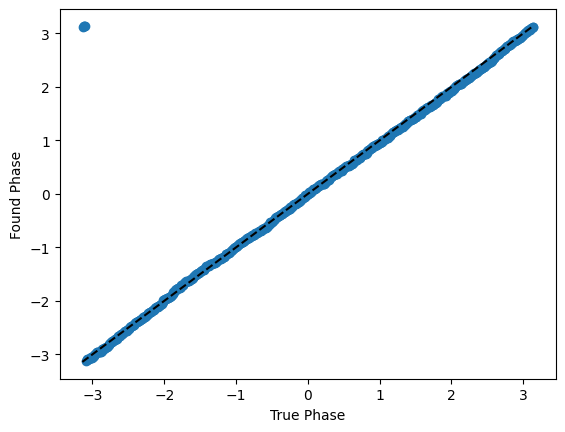

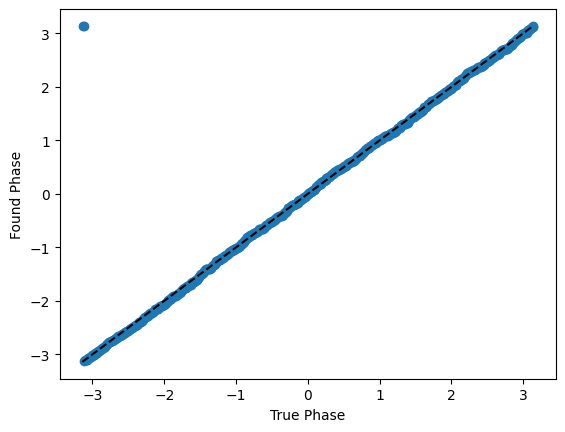

In [11]:
%matplotlib inline
fig, ax = plt.subplots()
refd_predicted_phases, refd_true_phases = compare_to_ground_truth(predicted_phases, angles, ax)


Now let's do a harder problem. Let's decode noisy data generated by a dynamic system. First, the dynamics. We will use a typical ring attractor model,

In [12]:
def conv_circ(signal, ker):
    return np.fft.ifft(np.einsum("ij, j -> ij", np.fft.fft(signal, axis=1), np.fft.fft(ker)), axis=1)


def cosine_kernel(w_0, w_1, N):
    step = 2/(N)
    grid = np.arange(start=0, stop=2, step=step) * np.pi
    weights = -w_0 + w_1 * np.cos(grid)
    return weights


def ring_attractor_dynamics(state, kernel, bias_vec, nonlin_fn):
    if len(np.shape(state)) == 1:
        state = np.expand_dims(state, -1)
    state = np.transpose(state)
    return np.transpose(-state + nonlin_fn(conv_circ(state, kernel) + bias_vec))


def sigmoid(x):
    return np.exp(x)/(np.exp(x) + 1)

Generate some samples of equalibrium states. We will generate around 50, to make things interesting.

In [13]:
N = 2 ** 7
n_samples = 50

init_conds = np.random.uniform(-1, 1, (n_samples, N)).astype(np.complex)

w_0 = 1
w_1 = 1
kernel = cosine_kernel(w_0, w_1, N)


def run_equilibriation(init_conds):
    soln = integrate.solve_ivp(lambda _, y: ring_attractor_dynamics(y, kernel, np.zeros(N), sigmoid),
                               [0, 20], init_conds, vectorized=True)
    return soln.y[:, -1]


p = mp.Pool()
solns = np.array(p.map(run_equilibriation, init_conds))
p.close()
p.join()

/tmp/ipykernel_161331/1478060612.py:4: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  init_conds = np.random.uniform(-1, 1, (n_samples, N)).astype(np.complex)
/tmp/ipykernel_67152/1478060612.py:4: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  init_conds = np.random.uniform(-1, 1, (n_samples, N)).astype(np.complex)


Add some noise

In [14]:
ring_attractor_data = np.real(solns/np.mean(np.abs(solns)))
noisy_ring_attractor_data = ring_attractor_data + np.random.normal(0, np.max(ring_attractor_data)/15, np.shape(ring_attractor_data))

Note down the ground truth phases

In [15]:
true_ring_att_phases = (np.argmax(ring_attractor_data, axis=1)/N) * 2 * np.pi

Text(0, 0.5, 'Datapoint')

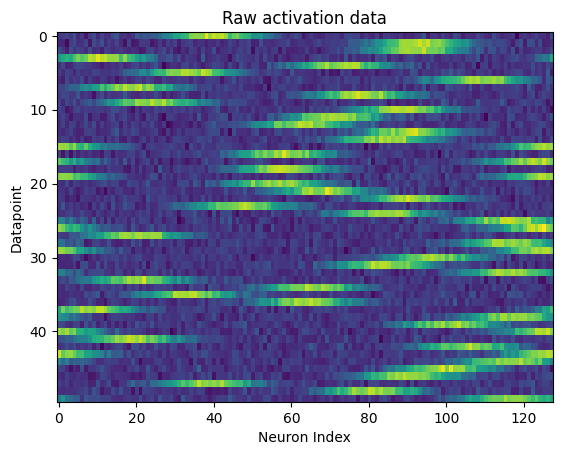

Text(0, 0.5, 'Datapoint')

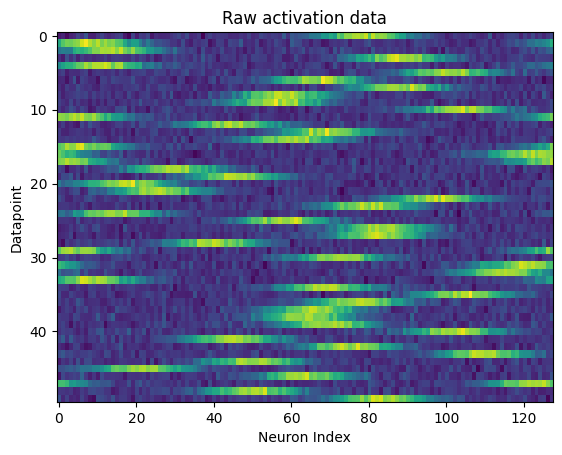

In [16]:
fig, ax = plt.subplots()
ax.imshow(noisy_ring_attractor_data, aspect="auto")
ax.set_title("Raw activation data")
ax.set_xlabel("Neuron Index")
ax.set_ylabel("Datapoint")


Now decode

In [40]:
encoder, decoder = s1_direct_product_decoder.train(data=noisy_ring_attractor_data, manifold_dim=1, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=0.1)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 4.3064188957214355, distance cost: 0.00239120633341372, order reduction: 0.0046319011598825455
iteration: 1, decoding loss: 3.6360256671905518, distance cost: 0.026919331401586533, order reduction: 0.0029443278908729553
iteration: 2, decoding loss: 3.0046772956848145, distance cost: 0.054366517812013626, order reduction: 0.0020011153537780046
iteration: 3, decoding loss: 2.7926719188690186, distance cost: 0.0350860096514225, order reduction: 0.005224388558417559
iteration: 4, decoding loss: 2.4392101764678955, distance cost: 0.013131939806044102, order reduction: 0.0031211392488330603
iteration: 5, decoding loss: 2.168358087539673, distance cost: 0.004803050309419632, order reduction: 0.003068084130063653
iteration: 6, decoding loss: 1.9558584690093994, distance cost: 0.0025720468256622553, order reduction: 0.002774423686787486
iteration: 7, decoding loss: 1.8122347593307495, distance cost: 0.006753856781870127, order reduction: 0.0028929749969393015
iterat

In [41]:
with torch.no_grad():
    decoded_points, decoded_angles = decoder(torch.tensor(noisy_ring_attractor_data, dtype=torch.get_default_dtype()).to(device))

ring_att_predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()

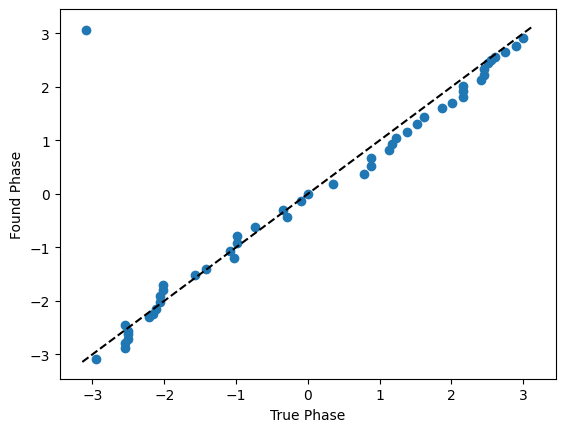

In [42]:
%matplotlib inline
fig, ax = plt.subplots()
refd_ring_att_predicted_phases, refd_ring_att_true_phases = compare_to_ground_truth(ring_att_predicted_phases, true_ring_att_phases, ax)
